In [1]:
import os

In [2]:
os.getcwd()

'C:\\Users\\ty\\PycharmProjects\\GAN\\models'

In [3]:
import yaml

with open ("cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [4]:
cfg

{'n_epochs': 200,
 'batch_size': 64,
 'lr': 0.0002,
 'b1': 0.5,
 'b2': 0.999,
 'n_cpu': 8,
 'latent_dim': 100,
 'img_size': 224,
 'channels': 3,
 'sample_interval': 400}

In [5]:
from argparse import Namespace

opt=Namespace(**cfg)

In [6]:
import pytorch_lightning as pl

In [7]:
from datasets import load_from_disk

# Read all images into a pd dataframe

In [8]:
import pandas as pd
from torchvision import transforms
from pathlib import Path  
from PIL import Image

images = [k for k in Path(r"C:\Users\ty\Downloads\Compressed\art_images\dataset\dataset_updated\training_set\engraving").iterdir() if k.is_file()]
images_ = []
for k in images:
    try:
      Image.open(k)
      images_.append(k)
    except:
      pass

del images


In [10]:
images_.__len__()

757

# this function will be applied later as MAP

In [45]:
from PIL import Image

def resize_and_pad(examples, target_size):
    
    
        img = examples['image']
        # Resize the image so that the smaller dimension is equal to the target size
        img_aspect = img.width / img.height
        target_aspect = target_size[0] / target_size[1]
        if img_aspect > target_aspect:
            # The image is wider than the target aspect ratio, so resize based on width
            new_width = target_size[0]
            new_height = int(target_size[0] / img_aspect)
        else:
            # The image is taller than the target aspect ratio, so resize based on height
            new_height = target_size[1]
            new_width = int(target_size[1] * img_aspect)
        img = img.resize((new_width, new_height), Image.BICUBIC)
    
        # Pad the image to make it square
        new_img = Image.new("RGB", target_size, (255, 255, 255))
        padding_left = (target_size[0] - new_width) // 2
        padding_top = (target_size[1] - new_height) // 2
        new_img.paste(img, (padding_left, padding_top))
        

        examples['resized_image'] = new_img
        return examples



In [12]:
from datasets import Image


In [13]:
images_ = {
  'image' : images_
}

In [18]:

df= pd.DataFrame.from_dict(images_)


In [19]:
df

,image
0,C:\Users\ty\Downloads\Compressed\art_images\da...
1,C:\Users\ty\Downloads\Compressed\art_images\da...
2,C:\Users\ty\Downloads\Compressed\art_images\da...
3,C:\Users\ty\Downloads\Compressed\art_images\da...
4,C:\Users\ty\Downloads\Compressed\art_images\da...
...,...
752,C:\Users\ty\Downloads\Compressed\art_images\da...
753,C:\Users\ty\Downloads\Compressed\art_images\da...
754,C:\Users\ty\Downloads\Compressed\art_images\da...
755,C:\Users\ty\Downloads\Compressed\art_images\da...


In [22]:
df['image'] = df['image'].apply(lambda x : x.as_posix())

# read as HF datasets from DF

In [23]:
df.to_json('images.jsonl', orient='records', lines=True)

In [33]:
from datasets import load_dataset

ds = load_dataset("json", data_files=r"C:\Users\ty\PycharmProjects\GAN\models\images.jsonl")


Found cached dataset json (C:/Users/ty/.cache/huggingface/datasets/json/default-cb3112f1fc5697ad/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
ds['train'][0]

{'image': 'C:/Users/ty/Downloads/Compressed/art_images/dataset/dataset_updated/training_set/engraving/1.jpg'}

In [36]:
from datasets.features import  Image

ds = ds.cast_column("image", Image())

In [39]:
ds['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=935x693>}

In [47]:
from functools import partial

resize_mapper = partial(
    resize_and_pad,
    target_size=(512, 512),
)

ds = ds['train'].map(
    resize_mapper,
    remove_columns=['image'],
)


Map:   0%|          | 0/757 [00:00<?, ? examples/s]

In [48]:
ds.save_to_disk("../dataset")

Saving the dataset (0/1 shards):   0%|          | 0/757 [00:00<?, ? examples/s]

# plotting the image

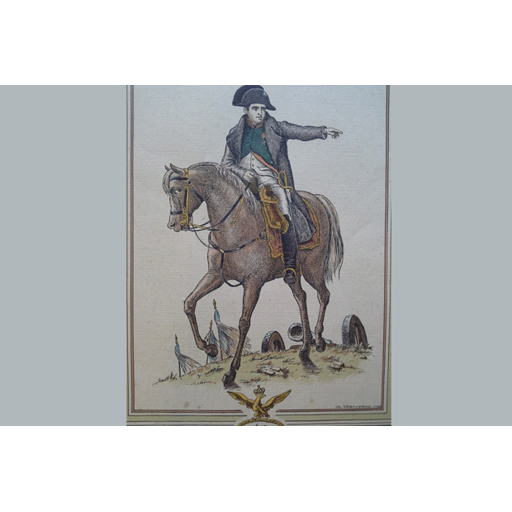

In [55]:
ds['resized_image'][100]

# apply the augmentations and define collator

In [80]:
# import dataloader
from torch.utils.data import DataLoader
from datasets import load_from_disk
from torchvision import transforms

ds = load_from_disk("../dataset")
transform_image=transforms.Compose(
            [
                transforms.Resize((512, 512)), 
                 transforms.ToTensor(), 
                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
             ]
)

    
def transforms(examples):
    examples["pixel_values"] = [transform_image(image.convert("RGB")) for image in examples["resized_image"]]
    return examples
    
ds.set_transform(transforms)



In [81]:
ds.features

{'resized_image': Image(decode=True, id=None)}

In [83]:
ds[0].keys()

dict_keys(['resized_image', 'pixel_values'])

dict_keys(['resized_image', 'pixel_values'])

In [86]:
ds[0]['pixel_values'].shape

torch.Size([3, 512, 512])

In [87]:
import torch

def collate(examples):
    # from prev. step , each sample of example will have keys : pixel_values, resized_image
    # pixel_values will be tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    return pixel_values

In [88]:
dl = DataLoader(ds, batch_size=4, collate_fn=collate)

# plotting a batch from DL

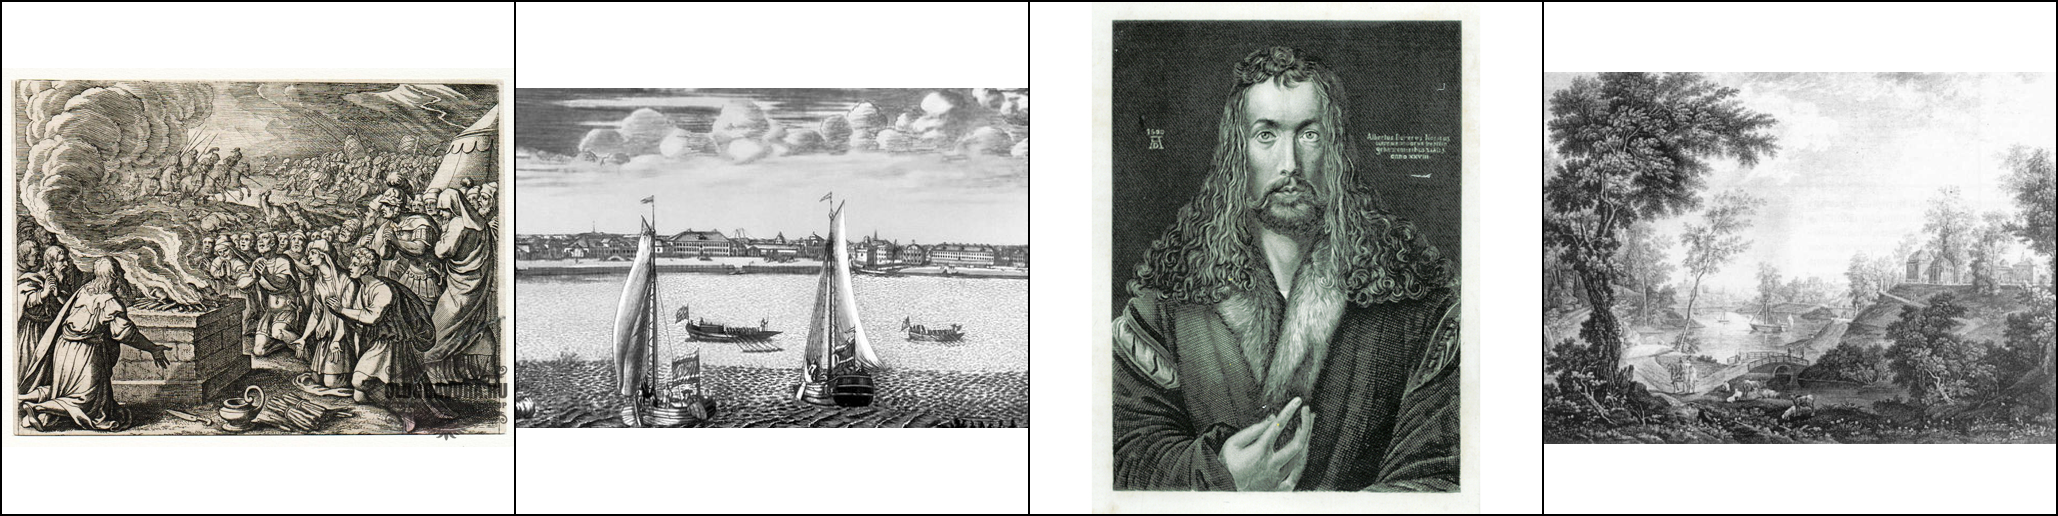

In [90]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image


to_pil_image(make_grid(next(iter(dl)), nrow=4, normalize=True))

In [92]:
ds.select(range(10)).shuffle

Dataset({
    features: ['resized_image'],
    num_rows: 10
})

In [95]:
from omegaconf import OmegaConf

conf = OmegaConf.load("cfg.yaml")


In [96]:

conf

{'epochs': 200, 'img_size': 224, 'latent_dim': 100, 'channels': 3, 'ds_path': 'C:/Users/ty/PycharmProjects/GAN/dataset', 'batch_size': 8, 'shuffle': True, 'num_workers': 0, 'lr_dis': 0.0002, 'lr_gen': 0.0002}

In [99]:
from discriminator import Discriminator

disc = Discriminator(channels=conf.channels, img_size=conf.img_size)

In [100]:
disc.to('cuda')

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [103]:
for k in disc.children():
    print(k)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout2d(p=0.25, inplace=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Dropout2d(p=0.25, inplace=False)
  (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Dropout2d(p=0.25, inplace=False)
  (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): LeakyReLU(negative_slope=0.2, inplace=True)
  (13): Dropout2d(p=0.25, inplace=False)
  (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
)
Sequential(
  (0): Linear(in_features=25088, out_features=1, bias=Tru

In [116]:
random_image = torch.randn(10, 3, 224, 224).to('cuda')
disc(random_image).shape

torch.Size([10, 1])

In [119]:
elem = sum([k.numel() for k in disc.parameters() if k.requires_grad])

In [121]:
print(f"trainable params --> {elem}")

trainable params --> 122977


# test the generator

In [122]:
from generator import Generator

In [123]:
gen = Generator(channels=conf.channels, img_size=conf.img_size, latent_dim=conf.latent_dim)

In [124]:
random = torch.randn(10, 100).to('cuda')

In [125]:
gen.to('cuda')
gen(random).shape

torch.Size([10, 3, 224, 224])